In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

## Dataset and visualisation

In [17]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, 
                                      transform=transforms.ToTensor())

In [18]:
batch_size = 4

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [19]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
2


In [20]:
def imshow(img, title):    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [21]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

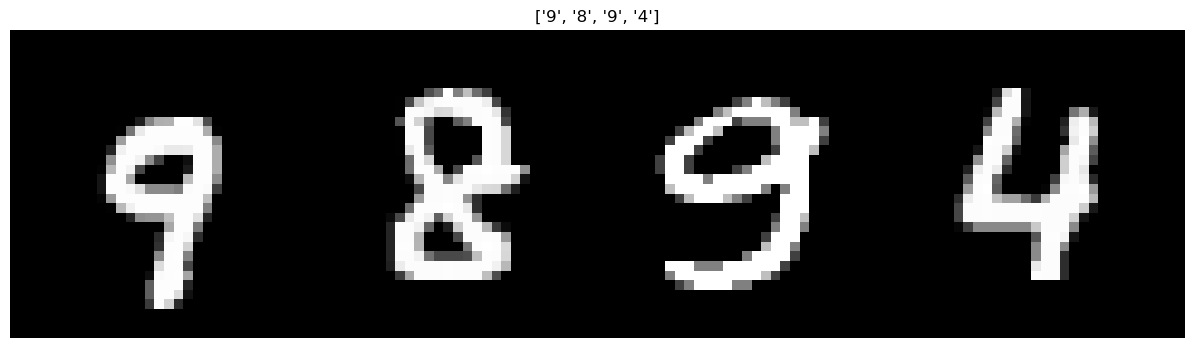

In [22]:
images, labels = show_batch_images(trainloader)

In [23]:
class Model(nn.Module):
    def __init__(self): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [24]:
class ModelBN(nn.Module):
    def __init__(self): 
        super(ModelBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [25]:
model = Model()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [26]:
model_bn = ModelBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [27]:
batch_size = 512

In [28]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [29]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

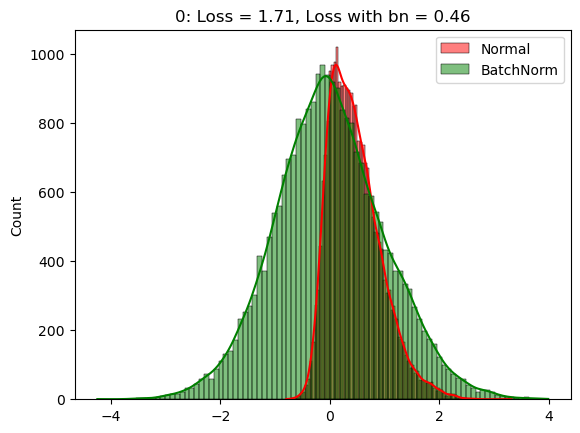

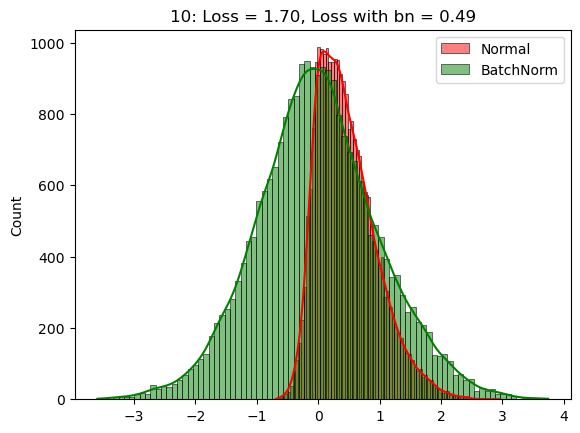

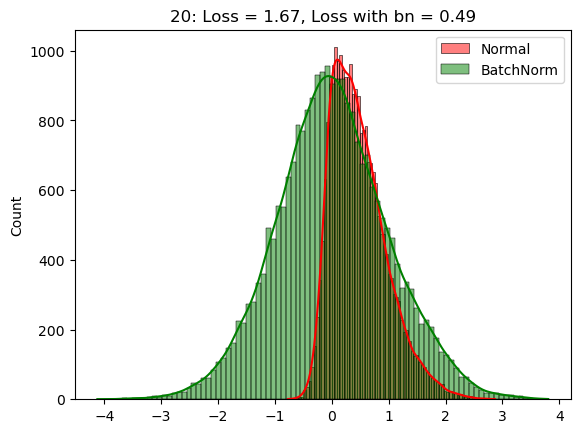

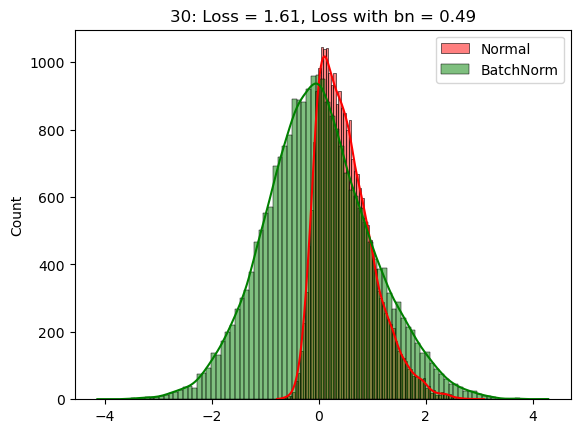

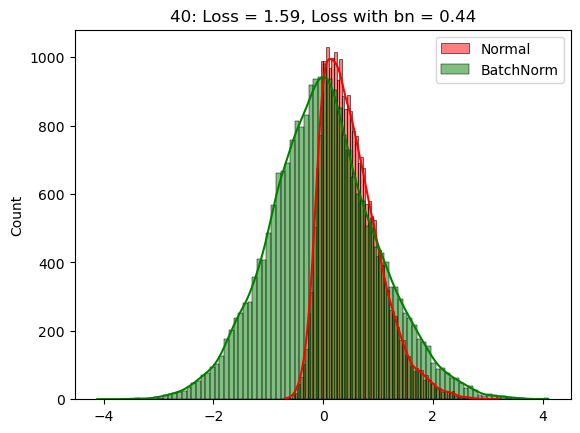

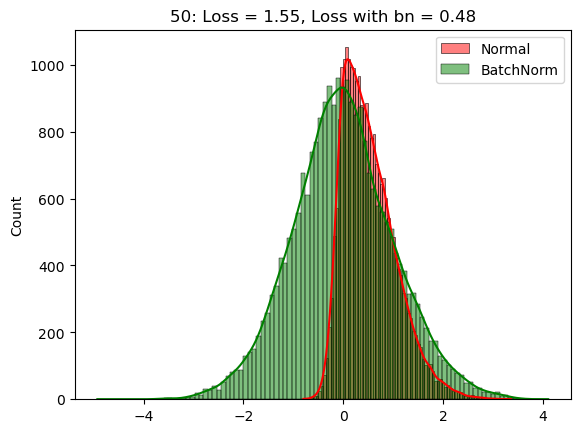

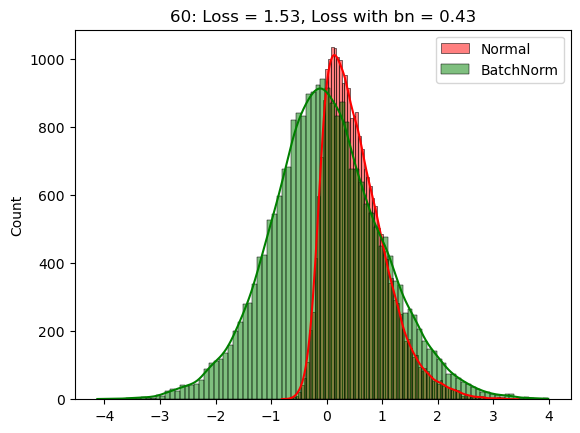

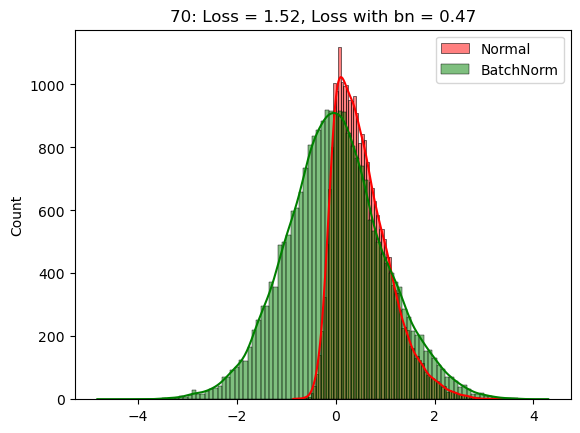

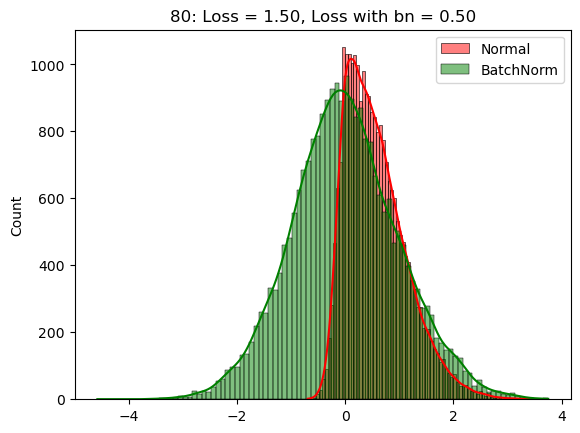

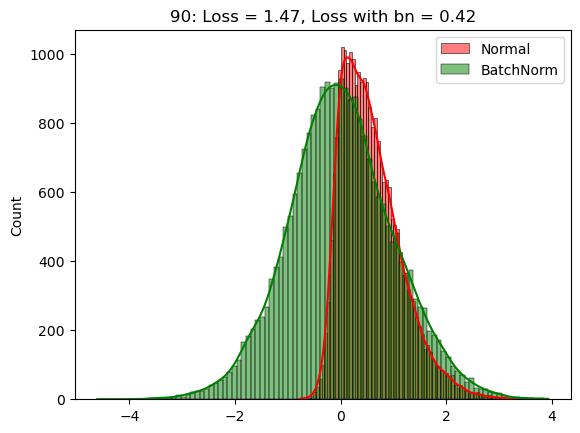

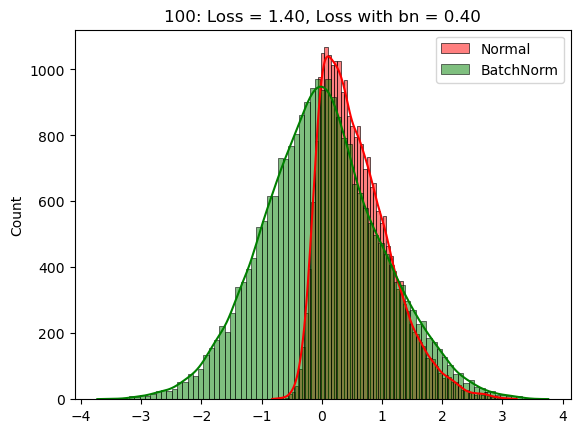

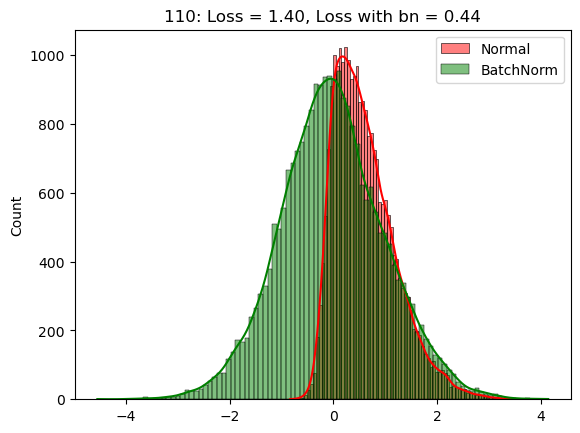

----------------------


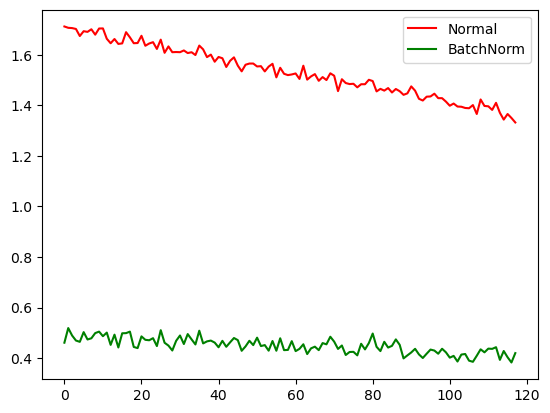

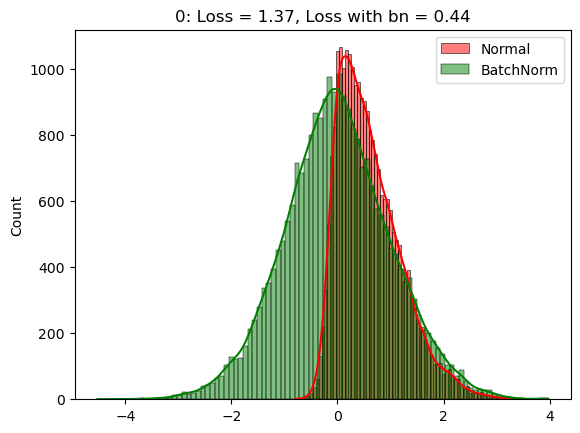

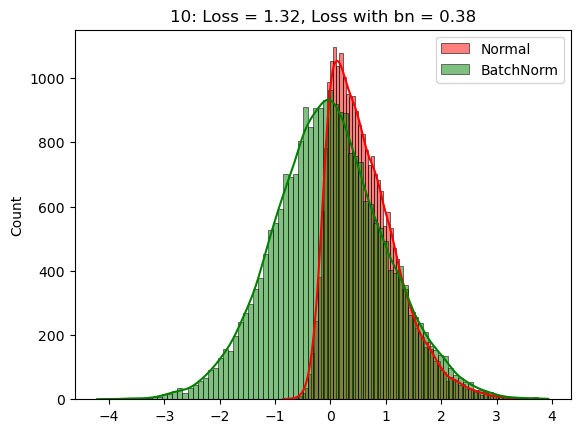

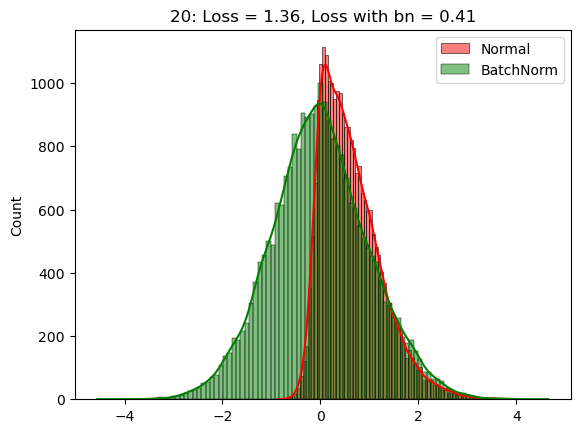

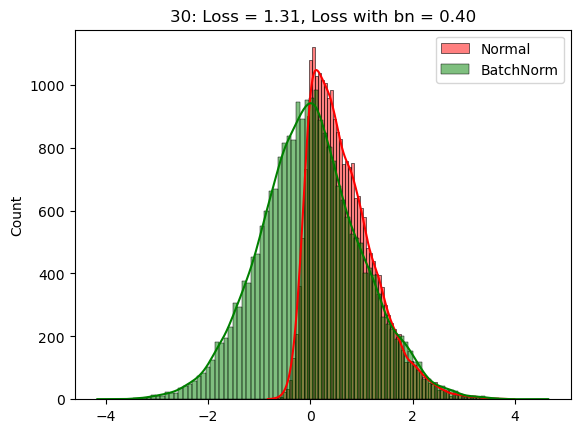

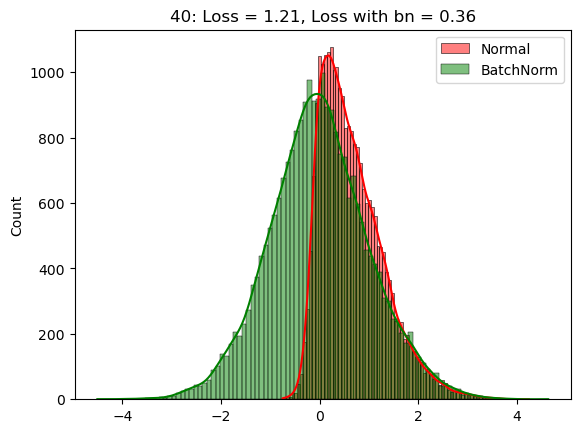

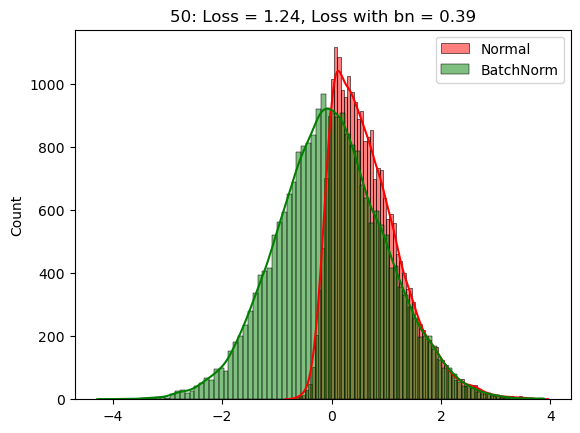

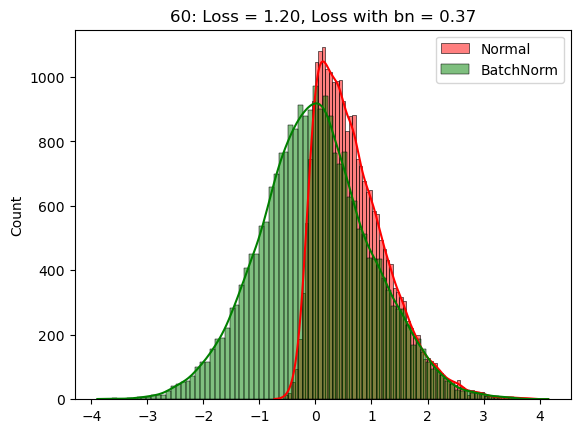

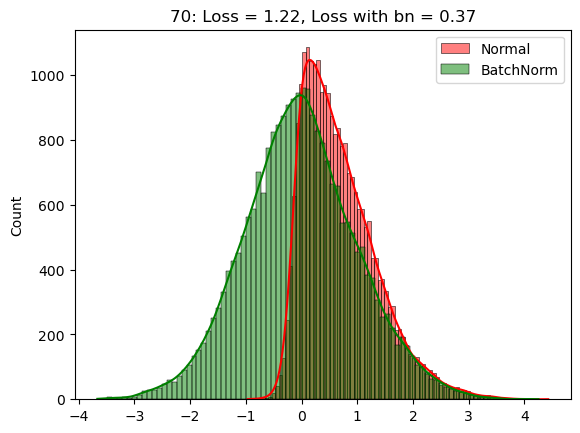

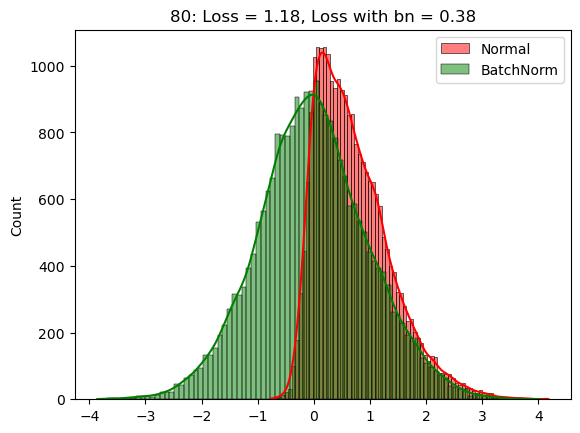

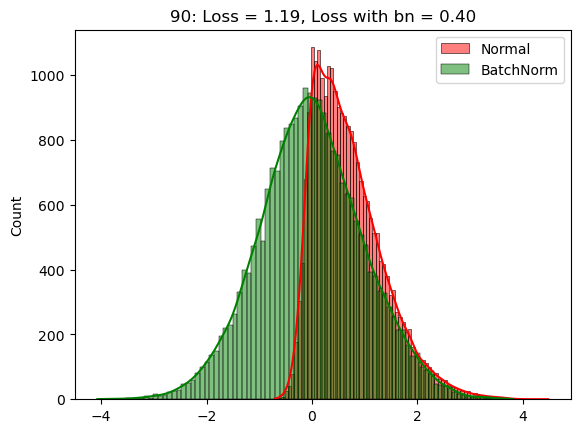

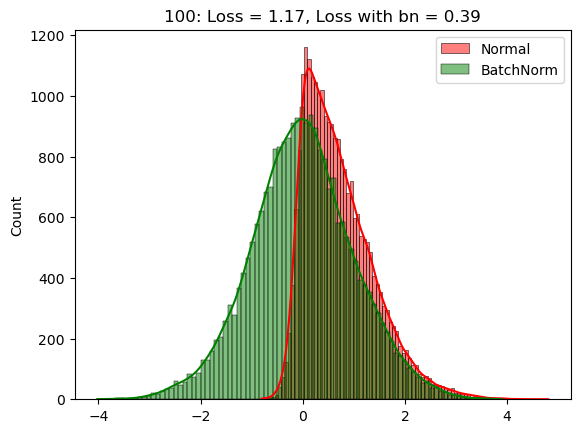

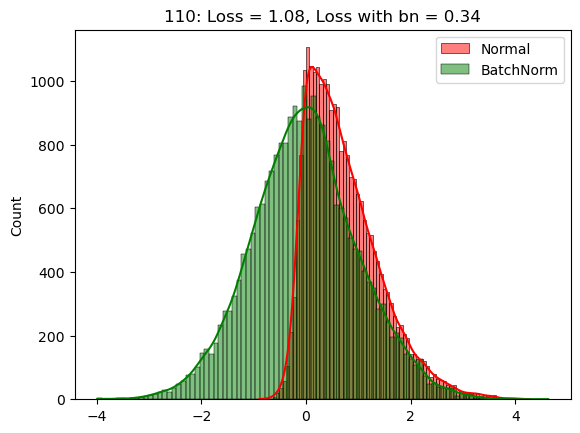

----------------------


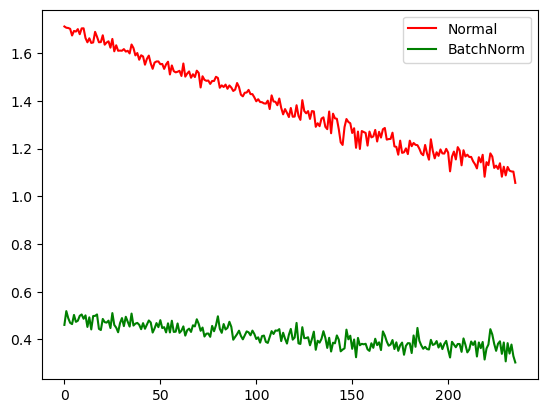

In [33]:
loss_arr = []
loss_bn_arr = []

max_epochs = 2

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        # training steps for normal model
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
        if i % 10 == 0:
        
            inputs = inputs.view(inputs.size(0), -1)
            
            model.eval()
            model_bn.eval()
            
            a = model.classifier[0](inputs)
            a = a.detach().numpy().ravel()
            sns.histplot(a, kde=True, color='r', label='Normal') 
            
            b = model_bn.classifier[0](inputs)
            b = model_bn.classifier[1](b)
            b = b.detach().numpy().ravel()
            
            sns.histplot(b, kde=True, color='g', label='BatchNorm') 
            plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)
            
            model.train()
            model_bn.train()        
        
    print('----------------------')

    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.legend()
    plt.show()

In [ ]:
class CNN_BN(nn.Module):
    def __init__(self): 
        super(ModelBN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 3, 5),         # (N, 1, 28, 28) -> (N,  3, 24, 24)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 3, 24, 24) -> (N,  3, 12, 12)
            nn.Conv2d(3, 6, 3),
            nn.BatchNorm2d(6)           # (N, 3, 12, 12) -> (N,  6, 10, 10) 
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N, 6, 10, 10) -> (N,  6, 5, 5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(150, 25),         # (N, 150) -> (N, 25)
            nn.ReLU(),
            nn.Linear(25,10)            # (N, 25) -> (N, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x